In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import scipy
import skimage
import tensorflow as tf
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './dataset/notmnist' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./dataset/notmnist/notMNIST_large.tar.gz
Found and verified ./dataset/notmnist/notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders  = maybe_extract(test_filename)

./dataset/notmnist/notMNIST_large already present - Skipping extraction of ./dataset/notmnist/notMNIST_large.tar.gz.
['./dataset/notmnist/notMNIST_large/A', './dataset/notmnist/notMNIST_large/B', './dataset/notmnist/notMNIST_large/C', './dataset/notmnist/notMNIST_large/D', './dataset/notmnist/notMNIST_large/E', './dataset/notmnist/notMNIST_large/F', './dataset/notmnist/notMNIST_large/G', './dataset/notmnist/notMNIST_large/H', './dataset/notmnist/notMNIST_large/I', './dataset/notmnist/notMNIST_large/J']
./dataset/notmnist/notMNIST_small already present - Skipping extraction of ./dataset/notmnist/notMNIST_small.tar.gz.
['./dataset/notmnist/notMNIST_small/A', './dataset/notmnist/notMNIST_small/B', './dataset/notmnist/notMNIST_small/C', './dataset/notmnist/notMNIST_small/D', './dataset/notmnist/notMNIST_small/E', './dataset/notmnist/notMNIST_small/F', './dataset/notmnist/notMNIST_small/G', './dataset/notmnist/notMNIST_small/H', './dataset/notmnist/notMNIST_small/I', './dataset/notmnist/not

In [4]:
import random

# Visualise a sample of each label
def display_images(filename, samples_per_label):
    print ('Displaying images in: ', filename)
    folder = os.path.join(data_root, filename)
    for label in sorted(os.listdir(folder)):
        if(label.endswith('.pickle') == False):
            print ('Label: ', label)
            label_folder = os.path.join(folder, label)
            dirs = os.listdir(label_folder)
            random.shuffle(dirs)
            for image in dirs[:samples_per_label]:
                display(Image(filename=os.path.join(label_folder, image), width=20.0, height=20.0))
            
display_images('notMNIST_large', 5)
display_images('notMNIST_small', 5)

Displaying images in:  notMNIST_large
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


Displaying images in:  notMNIST_small
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


In [5]:
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./dataset/notmnist/notMNIST_large/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/C.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/D.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/E.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/F.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/G.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/H.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/I.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/J.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/C.pick

Displaying pickles from train dataset


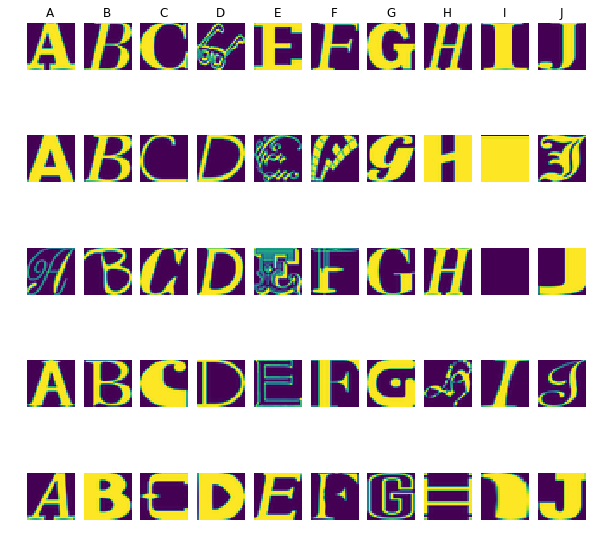

Displaying pickles from test dataset


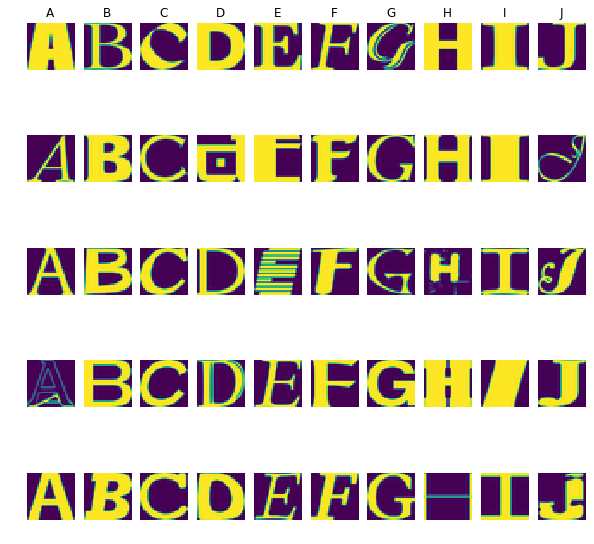

In [7]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_labels = len(labels)

def display_pickle(dataset, samples_per_label):
    for y, label in enumerate(labels):
        pickles = pickle.load(open(dataset[y], 'rb'))
        idxs = np.random.choice(pickles.shape[0], samples_per_label, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_labels + y + 1
            plt.subplot(samples_per_label, num_labels, plt_idx)
            plt.imshow(pickles[idx, :, :])
            plt.axis('off')
            if i == 0:
                plt.title(label)
    plt.show()
    

print ('Displaying pickles from train dataset')
display_pickle(train_datasets, 5)
print ('Displaying pickles from test dataset')
display_pickle(test_datasets, 5)

In [8]:
img_size = image_size
new_size = (28, 56)

def make_arrays(nb_rows, size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, size[0], size[1]), dtype=np.float32)
        labels = np.ndarray((nb_rows, 5), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, dataset_size):
    dataset, labels = make_arrays(dataset_size, new_size)
    pickles = []
    for i in range(10):
        pickles.append(pickle.load(open(pickle_files[i], 'rb')))

    for i in range(dataset_size):
        # Generate a random label with max length 5 chars
        data_length  = np.random.choice(5, 1)[0] + 1
#         data_length = 5
        random_chars = np.random.choice(10, data_length)
#         random_chars = np.random.choice(9, data_length)
        data_label   = np.append(random_chars, np.full(5 - data_length, 10, dtype=int))
        
        chars = []
        
        for char in random_chars:
            index = np.random.choice(len(pickles[char]), 1)
            chars.append(np.reshape(pickles[char][index, :, :], (img_size, img_size)))

        image = np.ndarray((img_size, data_length * img_size))
        
        for idx, char in enumerate(chars):
            image[:, img_size*idx:img_size*(idx+1)] = char

        image = skimage.transform.resize(image, new_size)

        dataset[i] = image
        labels[i]  = data_label
    return (dataset, labels)

if not os.path.exists(os.path.join(data_root, 'train_no_length.pickle')):
    train = merge_datasets(train_datasets, 200000)
    saveAsPickle(train, os.path.join(data_root, 'train_no_length.pickle'))
else:
    print('Train dataset already exists')
    train = loadPickle(os.path.join(data_root, 'train_no_length.pickle'))
if not os.path.exists(os.path.join(data_root, 'valid_no_length.pickle')):
    valid = merge_datasets(train_datasets, 5000)
    saveAsPickle(valid, os.path.join(data_root, 'valid_no_length.pickle'))
else:
    print('Validation dataset already exists')
    valid = loadPickle(os.path.join(data_root, 'valid_no_length.pickle'))
if not os.path.exists(os.path.join(data_root, 'test_no_length.pickle')):
    test  = merge_datasets(test_datasets, 10000)
    saveAsPickle(test, os.path.join(data_root, 'test_no_length.pickle'))
else:
    print('Test dataset already exists')
    test  = loadPickle(os.path.join(data_root, 'test_no_length.pickle'))

Train dataset already exists
Validation dataset already exists
Test dataset already exists


In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train[0], train[1])
test_dataset, test_labels = randomize(test[0], test[1])
valid_dataset, valid_labels = randomize(valid[0], valid[1])

Displaying training images
[[5 8 6 3 6]
 [8 5 3 4 1]
 [6 8 0 0 6]]


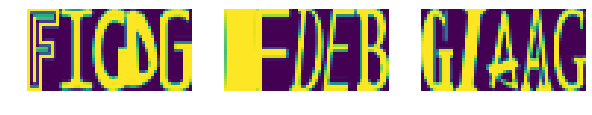

Displaying test images
[[1 8 5 2 5]
 [0 0 7 0 1]
 [0 4 1 6 7]]


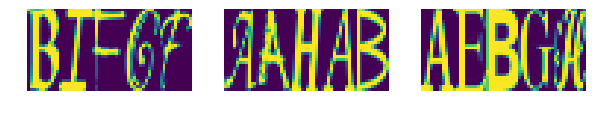

Displaying validation images
[[0 5 4 0 0]
 [5 4 2 0 6]
 [2 8 6 2 8]]


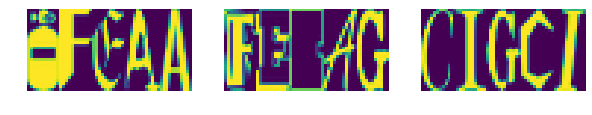

In [10]:
def display_dataset(dataset, labels, samples_per_label):
    idxs = np.random.choice(dataset.shape[0], samples_per_label, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i + 1
        plt.subplot(1, samples_per_label, plt_idx)
        plt.imshow(dataset[idx])
        plt.axis('off')
    print(labels[idxs])
    plt.show()
    
print ('Displaying training images')
display_dataset(train_dataset, train_labels, 3)
print ('Displaying test images')
display_dataset(test_dataset, test_labels, 3)
print ('Displaying validation images')
display_dataset(valid_dataset, valid_labels, 3)

In [11]:
new_size = (28, 56)
num_labels = 11
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, new_size[0], new_size[1], num_channels)).astype(np.float32)
    labels = np.eye(11)[labels]
    
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 56, 1) (200000, 5, 11)
Validation set (5000, 28, 56, 1) (5000, 5, 11)
Test set (10000, 28, 56, 1) (10000, 5, 11)


In [12]:
def accuracy(predictions, labels):
    predictions = np.transpose(predictions, (1, 0, 2))
    global_acc = 100.0 * np.mean(np.prod(np.argmax(predictions, 2) == np.argmax(labels, 2), 1))
    individual_acc = 100 *np.mean(np.argmax(predictions,2) == np.argmax(labels, 2), 0)
    return [global_acc, individual_acc]

## Network

In [13]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64
image_size = (28, 56)
num_outputs = 5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size[0], image_size[1], num_channels))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_outputs, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
  
    # Variables.
    ## First convolutional layer
    conv1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    conv1_biases  = tf.Variable(tf.zeros([depth]))
    
    ## Second convolutional layer
    conv2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    conv2_biases  = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    ## fully connected layer
    fc1_weights = tf.Variable(tf.truncated_normal(
        [image_size[0] // 4 * image_size[1] // 4 * depth, num_hidden], stddev=0.1))
    fc1_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    ## softmax
    softmax1_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax1_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax2_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax3_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax3_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax4_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax5_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        # first conv
        conv   = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv1_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # second conv
        conv   = tf.nn.conv2d(hidden, conv2_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv2_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # flatten
        shape   = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # fc
        hidden  = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        # classifiers
        classifier1 = tf.matmul(hidden, softmax1_weights) + softmax1_biases
        classifier2 = tf.matmul(hidden, softmax2_weights) + softmax2_biases
        classifier3 = tf.matmul(hidden, softmax3_weights) + softmax3_biases
        classifier4 = tf.matmul(hidden, softmax4_weights) + softmax4_biases
        classifier5 = tf.matmul(hidden, softmax5_weights) + softmax5_biases
        
        return [classifier1, classifier2, classifier3, classifier4, classifier5]
  
    # Training computation.
    logits = model(tf_train_dataset)
    
    total_loss = 0
    for i in range(len(logits)):
        total_loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=tf_train_labels[:, i], logits=logits[i]))
    tf_loss_summary = tf.summary.scalar('loss', total_loss)
        
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(total_loss)
  
    # Predictions for the training, validation, and test data.
    def prediction(logits):
        prediction = []
        for logit in logits:
            prediction.append(tf.nn.softmax(logit))
        return tf.stack(prediction)
    
    train_predictions = prediction(logits)
    
    valid_predictions = prediction(model(tf_valid_dataset))
    
    test_predictions = prediction(model(tf_test_dataset))

In [15]:
num_steps = 7001

with tf.Session(graph=graph) as session:
    if not os.path.exists('summaries'):
        os.mkdir('summaries')
    writer = tf.summary.FileWriter('summaries', session.graph)
    
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, total_loss, train_predictions], feed_dict=feed_dict)
        if (step % 100 == 0):
            print(f'step {step}:')
            print(f'\tMinibatch loss: {l}')
            print(f'\tMinibatch accuracies: {accuracy(predictions, batch_labels)}')
            print(f'Validation accuracies: {accuracy(valid_predictions.eval(), valid_labels)}')

    print(f'\nTest accuracies: {accuracy(test_predictions.eval(), test_labels)}')

Initialized
step 0:
	Minibatch loss: 21.575414657592773
	Minibatch accuracies: [0.0, array([ 0.   , 18.75 , 18.75 ,  9.375,  6.25 ])]
Validation accuracies: [0.0, array([11.68, 11.24, 11.04, 10.04, 11.1 ])]
step 100:
	Minibatch loss: 9.19070053100586
	Minibatch accuracies: [0.0, array([46.875, 34.375, 46.875, 21.875, 34.375])]
Validation accuracies: [0.12, array([29.2 , 26.34, 30.86, 24.5 , 31.84])]
step 200:
	Minibatch loss: 6.357753276824951
	Minibatch accuracies: [3.125, array([56.25 , 59.375, 43.75 , 62.5  , 65.625])]
Validation accuracies: [2.88, array([53.54, 45.46, 45.5 , 53.12, 59.5 ])]
step 300:
	Minibatch loss: 5.785181999206543
	Minibatch accuracies: [12.5, array([59.375, 56.25 , 50.   , 75.   , 65.625])]
Validation accuracies: [8.88, array([62.48, 55.08, 61.06, 66.38, 67.52])]
step 400:
	Minibatch loss: 4.07443380355835
	Minibatch accuracies: [25.0, array([75.   , 75.   , 65.625, 65.625, 71.875])]
Validation accuracies: [11.360000000000001, array([68.1 , 65.52, 59.14, 65.48

Validation accuracies: [42.120000000000005, array([85.04, 83.34, 84.62, 84.22, 84.76])]
step 4100:
	Minibatch loss: 2.167698860168457
	Minibatch accuracies: [50.0, array([78.125, 87.5  , 84.375, 93.75 , 93.75 ])]
Validation accuracies: [42.480000000000004, array([85.32, 83.82, 84.64, 84.16, 84.52])]
step 4200:
	Minibatch loss: 2.409557819366455
	Minibatch accuracies: [46.875, array([93.75, 87.5 , 75.  , 81.25, 87.5 ])]
Validation accuracies: [43.26, array([85.26, 83.7 , 84.82, 85.22, 84.82])]
step 4300:
	Minibatch loss: 3.4230473041534424
	Minibatch accuracies: [31.25, array([84.375, 90.625, 71.875, 81.25 , 75.   ])]
Validation accuracies: [42.54, array([84.66, 84.42, 84.72, 85.54, 84.08])]
step 4400:
	Minibatch loss: 2.9876270294189453
	Minibatch accuracies: [37.5, array([78.125, 87.5  , 84.375, 84.375, 78.125])]
Validation accuracies: [42.28, array([84.94, 84.04, 84.98, 84.46, 84.86])]
step 4500:
	Minibatch loss: 2.982471466064453
	Minibatch accuracies: [37.5, array([90.625, 78.125, 